In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [6]:
Wgamma_fidcross  = 632.8869742335767
Wjets_fidcross   = 648.9972420521739
ttgamma_fidcross = 28.672233666666664
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1310.556449952417

In [8]:
sample = 250000 #22800 # # of signal and background events to plot their distributions

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

120729
123802
5469


In [9]:
##############
# input data #
##############

# photon -> (pT, eta, phi) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets)  HT: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])

In [5]:
os.listdir('../data/Signal/')

['MET.dat',
 'BP1_lepton_pruebaRO-sinMET.dat',
 'photon.dat',
 'BP0_lepton_pruebaRO.dat',
 'BP1_photon_pruebaRO-sinMET.dat',
 'BP1_MET.dat',
 'BP0_photon_pruebaRO-sinMET.dat',
 'BP0_photon_pruebaRO.dat',
 'BP0_photon.dat',
 'BP0_jet.dat',
 'BP0_MET_pruebaRO-sinMET.dat',
 'lhco',
 'BP0_hadinfo.dat',
 'BP1_jet.dat',
 'hadinfo.dat',
 'BP1_photon.dat',
 'BP1_lepton.dat',
 'BP0_jet_pruebaRO.dat',
 'jet.dat',
 'lepton.dat',
 'BP0_MET_pruebaRO.dat',
 'BP0_hadinfo_pruebaRO-sinMET.dat',
 'BP0_MET.dat',
 'BP1_hadinfo_pruebaRO-sinMET.dat',
 'BP0_lepton_pruebaRO-sinMET.dat',
 'BP0_jet_pruebaRO-sinMET.dat',
 'BP0_hadinfo_pruebaRO.dat',
 'BP1_MET_pruebaRO-sinMET.dat',
 'BP1_hadinfo.dat',
 'BP0_lepton.dat',
 'BP1_jet_pruebaRO-sinMET.dat']

In [10]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
for i in range(1,2):
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_pruebaRO-sinMET.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_pruebaRO-sinMET.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_pruebaRO-sinMET.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_pruebaRO-sinMET.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_pruebaRO-sinMET.dat', delimiter=' ') )

In [11]:
print(jet_Wjets.shape)
for i in range(len(jet_NP)):
    print(jet_NP[i].shape)

(104867, 3)
(2909, 3)


In [12]:
# other variables, individual channels:

HT_main_Wgamma = photon_Wgamma[:,0]+lepton_Wgamma[:,0]+jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0],np.sqrt(HT_main_Wgamma) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0]+lepton_Wgamma[:,0]+jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi] = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi] = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

HT_main_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(HT_main_Wjets) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi] = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi] = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



HT_main_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(HT_main_ttgamma) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi] = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi] = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

HT_main_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(HT_main_SM) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [13]:
# other variables NEW PHYSICS
HT_main_NP = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    HT_main_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(HT_main_NP[i]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [14]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(231065, 3)
(2909, 3)


In [15]:
cmap = cm.get_cmap('viridis', len(photon_NP) + 4)

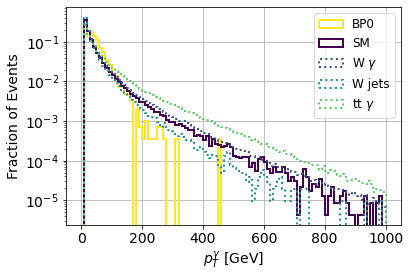

In [16]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    plt.hist(photon_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
plt.hist(photon_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
plt.hist(photon_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
plt.hist(photon_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
plt.hist(photon_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$p_T^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/pt_leadingPhoton_dist.png', bbox_inches='tight')

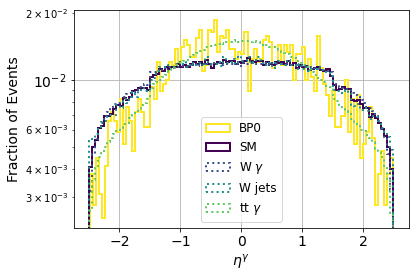

In [17]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    plt.hist(photon_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
plt.hist(photon_SM[:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
plt.hist(photon_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
plt.hist(photon_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
plt.hist(photon_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/pseudoRapidity_leadingPhoton_dist.png', bbox_inches='tight')

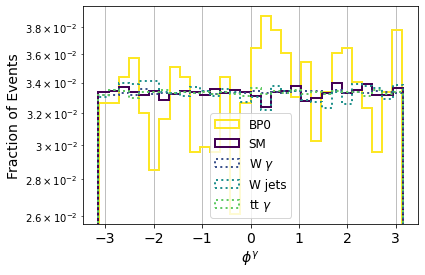

In [18]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,2])/len(photon_NP[i][:,2])
    plt.hist(photon_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(photon_SM[:,2])/len(photon_SM[:,2])
plt.hist(photon_SM[:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,2])/len(photon_Wgamma[:,2])
plt.hist(photon_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,2])/len(photon_Wjets[:,2])
plt.hist(photon_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,2])/len(photon_ttgamma[:,2])
plt.hist(photon_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/phi_leadingPhoton_dist.png', bbox_inches='tight')

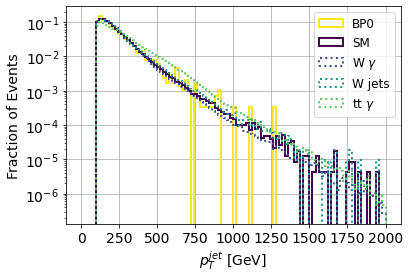

In [19]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    plt.hist(jet_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
plt.hist(jet_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
plt.hist(jet_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
plt.hist(jet_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
plt.hist(jet_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/pt_leadingJet_dist.png', bbox_inches='tight')

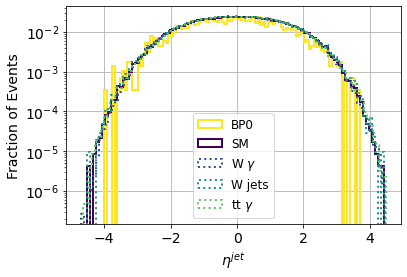

In [20]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    plt.hist(jet_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
plt.hist(jet_SM[:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
plt.hist(jet_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
plt.hist(jet_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
plt.hist(jet_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/pseudoRapidity_leadingJet_dist.png', bbox_inches='tight')

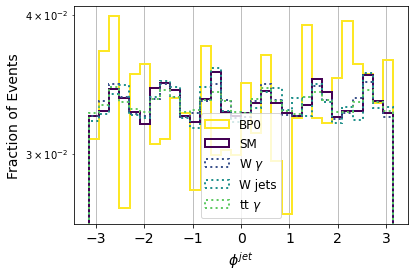

In [21]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,2])/len(jet_NP[i][:,2])
    plt.hist(jet_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(jet_SM[:,2])/len(jet_SM[:,2])
plt.hist(jet_SM[:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,2])/len(jet_Wgamma[:,2])
plt.hist(jet_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,2])/len(jet_Wjets[:,2])
plt.hist(jet_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,2])/len(jet_ttgamma[:,2])
plt.hist(jet_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/phi_leadingJet_dist.png', bbox_inches='tight')

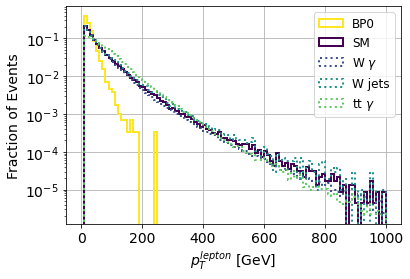

In [22]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    plt.hist(lepton_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
plt.hist(lepton_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
plt.hist(lepton_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
plt.hist(lepton_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
plt.hist(lepton_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/pt_leadingLepton_dist.png', bbox_inches='tight')

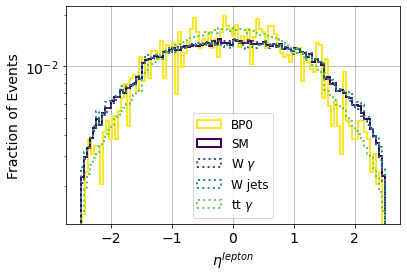

In [23]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    plt.hist(lepton_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
plt.hist(lepton_SM[:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
plt.hist(lepton_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
plt.hist(lepton_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
plt.hist(lepton_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/pseudoRapidity_leadingLepton_dist.png', bbox_inches='tight')

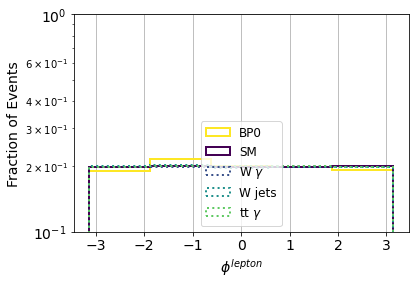

In [24]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,2])/len(lepton_NP[i][:,2])
    plt.hist(lepton_NP[i][:,2], weights=weights, bins=5, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(lepton_SM[:,2])/len(lepton_SM[:,2])
plt.hist(lepton_SM[:,2], weights=weights, bins=5, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,2])/len(lepton_Wgamma[:,2])
plt.hist(lepton_Wgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,2])/len(lepton_Wjets[:,2])
plt.hist(lepton_Wjets[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,2])/len(lepton_ttgamma[:,2])
plt.hist(lepton_ttgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.1,1)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/phi_leadingLepton_dist.png', bbox_inches='tight')

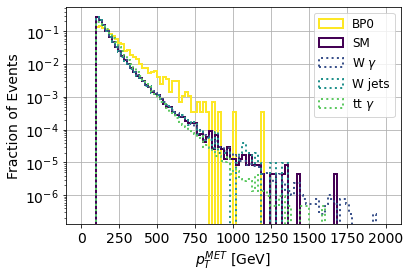

In [25]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    plt.hist(MET_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
plt.hist(MET_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
plt.hist(MET_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
plt.hist(MET_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
plt.hist(MET_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{MET}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/pt_MET_dist.png', bbox_inches='tight')

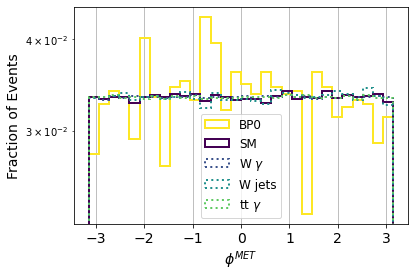

In [26]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,2])/len(MET_NP[i][:,2])
    plt.hist(MET_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)

weights = np.ones_like(MET_SM[:,2])/len(MET_SM[:,2])
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,2])/len(MET_Wgamma[:,2])
plt.hist(MET_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,2])/len(MET_Wjets[:,2])
plt.hist(MET_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,2])/len(MET_ttgamma[:,2])
plt.hist(MET_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{MET}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/phi_MET_dist.png', bbox_inches='tight')

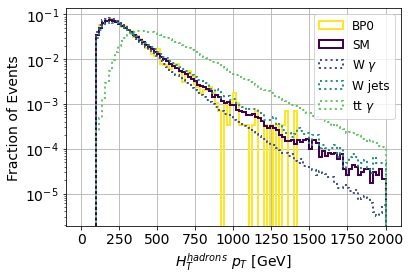

In [27]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    plt.hist(hadinfo_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
plt.hist(hadinfo_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
plt.hist(hadinfo_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
plt.hist(hadinfo_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{hadrons}$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/HadInfo_dist.png', bbox_inches='tight')

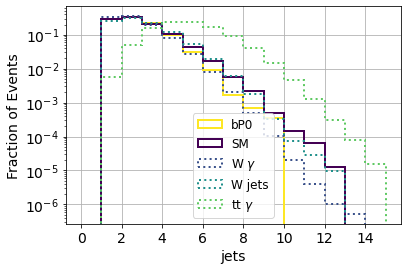

In [28]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    plt.hist(hadinfo_NP[i][:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(i + 4), histtype='step', label="bP" + str(i), zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
plt.hist(hadinfo_Wgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
plt.hist(hadinfo_Wjets[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
plt.hist(hadinfo_ttgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=12)
#plt.savefig('../graph/jets_dist.png', bbox_inches='tight')

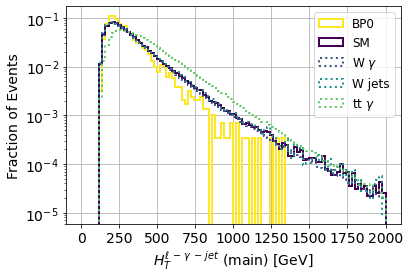

In [29]:
for i in range(len(photon_NP)):
    weights = np.ones_like(HT_main_NP[i])/len(HT_main_NP[i])
    plt.hist(HT_main_NP[i], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(HT_main_SM)/len(HT_main_SM)
plt.hist(HT_main_SM, weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(HT_main_Wgamma)/len(HT_main_Wgamma)
plt.hist(HT_main_Wgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(HT_main_Wjets)/len(HT_main_Wjets)
plt.hist(HT_main_Wjets, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(HT_main_ttgamma)/len(HT_main_ttgamma)
plt.hist(HT_main_ttgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{\ell \,-\, \gamma \,-\, jet}$ (main) [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/Ht_dist.png', bbox_inches='tight')

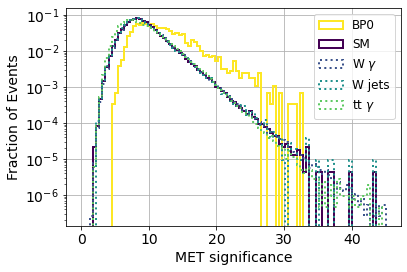

In [30]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    plt.hist(MET_sig_NP[i], weights=weights, bins=100, range=[0,45], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
plt.hist(MET_sig_SM, weights=weights, bins=100, range=[0,45], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
plt.hist(MET_sig_Wgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
plt.hist(MET_sig_Wjets, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
plt.hist(MET_sig_ttgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"MET significance",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/MET_significance_dist.png', bbox_inches='tight')

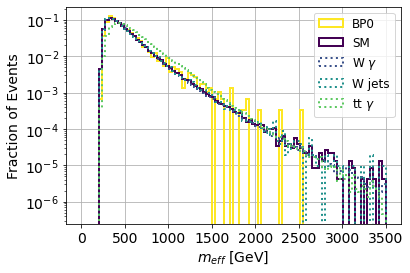

In [31]:
for i in range(len(photon_NP)):
    weights = np.ones_like(m_eff_NP[i])/len(m_eff_NP[i])
    plt.hist(m_eff_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(m_eff_SM)/len(m_eff_SM)
plt.hist(m_eff_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(m_eff_Wgamma)/len(m_eff_Wgamma)
plt.hist(m_eff_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(m_eff_Wjets)/len(m_eff_Wjets)
plt.hist(m_eff_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(m_eff_ttgamma)/len(m_eff_ttgamma)
plt.hist(m_eff_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{eff}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/Meff_dist.png', bbox_inches='tight')

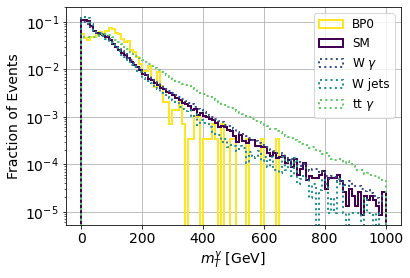

In [32]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    plt.hist(mT_photon_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
plt.hist(mT_photon_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
plt.hist(mT_photon_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
plt.hist(mT_photon_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
plt.hist(mT_photon_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/mt_photon_dist.png', bbox_inches='tight')

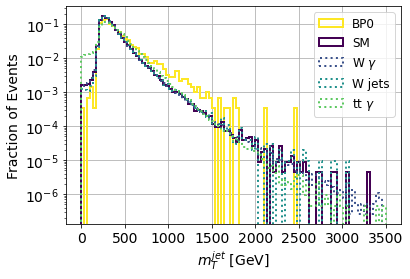

In [33]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    plt.hist(mT_jet_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
plt.hist(mT_jet_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
plt.hist(mT_jet_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
plt.hist(mT_jet_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
plt.hist(mT_jet_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/mt_Jet_dist.png', bbox_inches='tight')

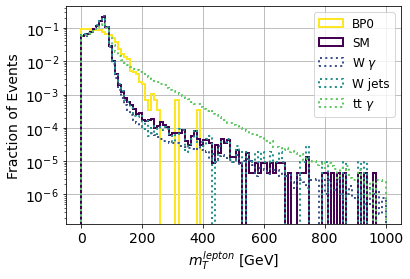

In [34]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    plt.hist(mT_lepton_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i + 4), histtype='step', label="BP" + str(i), zorder=2)
    
weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
plt.hist(mT_lepton_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(0), histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
plt.hist(mT_lepton_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(1), histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
plt.hist(mT_lepton_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(2), histtype='step', label="W jets")
weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
plt.hist(mT_lepton_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor=cmap(3), histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
#plt.savefig('../graph/mt_Lepton_dist.png', bbox_inches='tight')